In [1]:
import os
import argparse
import yaml
import time
import numpy as np
import pandas as pd
from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



import torch 
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn



from ili.dataloaders import StaticNumpyLoader
from ili.inference import InferenceRunner
from ili.validation import ValidationRunner



from CASBI.utils.create_dataframe import rescale
from CNN import ConvNet

In [3]:
if __name__ == '__main__':

    # N_subhalos = 2
    data = pd.read_parquet('../../../../data/dataframe/dataframe.parquet')
    data = rescale(data, mean_and_std_path='../../../../data/preprocess/mean_and_std.parquet', scale_observations=True, scale_parameter=True, inverse=True) 
    data =  data.drop(['gas_log10mass', 'a','redshift', 'mean_metallicity', 'std_metallicity','mean_FeMassFrac', 'std_FeMassFrac', 'mean_OMassFrac', 'std_OMassFrac'], axis=1)
    min_feh, max_feh = min(data['feh']), max(data['feh'])
    min_ofe, max_ofe = min(data['ofe']), max(data['ofe'])

    
    # N_test = 1_000
    def preprocess_testset(N_subhalos):
        # N_subhalos = np.random.randint(2, 101)
        galaxies = set(data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=int(time.time())))
        parameters =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T
        sorted_index = np.argsort(parameters[0], )[::-1]
        parameters = (parameters[:,sorted_index]).reshape(-1)
        galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
        histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
        sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
        return N_subhalos, sim_data, galaxies
    
    arr = np.concatenate([np.repeat(i, 10) for i in range(2, 101)])
    np.random.shuffle(arr)
    # Create a pool of workers
    with Pool() as pool:
        # Map the function to the data
        results = pool.map(preprocess_testset, arr)
        
    # Unpack the results
    N_subhalos_test, x_test, galaxies_test = zip(*results)
    
    N_subhalos_test = np.array(N_subhalos_test)-2 #so now it starts from 0 to 98, to encode from 2 to 100 subhalos
    
    #take the first test set element as x_0 and theta_0    
    galaxies_0 = galaxies_test[0]
    data_to_plot_halos = data[data['Galaxy_name'].isin(galaxies_0)].to_parquet('./halos_0.parquet')
    N_subhalos_0 = N_subhalos_test[0]
    x_0 =  x_test[0]

    def process_sample(N_subhalos):
        # N_subhalos = np.random.randint(2, 101)
        galaxies = data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=int(time.time()))
        while (any(set(galaxies) == galaxy_in_testset for galaxy_in_testset in galaxies_test)):
            print('matched galaxies, try again')
            print('galaxies', set(galaxies))
            print('test galaxies', galaxies_test)
            galaxies = data['Galaxy_name'].drop_duplicates().sample(N_subhalos, random_state=int(time.time()))
        parameters =  data[data['Galaxy_name'].isin(galaxies)].drop(['feh', 'ofe', 'Galaxy_name'], axis=1).drop_duplicates().values.T
        sorted_index = np.argsort(parameters[0], )[::-1]
        parameters = (parameters[:,sorted_index]).reshape(-1)
        galaxy_data = data[data['Galaxy_name'].isin(galaxies)].values
        histogram_galaxy, _, _ = np.histogram2d(galaxy_data[:, 0], galaxy_data[:, 1], bins=64, range=[[min_feh, max_feh], [min_ofe, max_ofe]])
        sim_data =  np.expand_dims(np.log10(histogram_galaxy + 1e-6 +1), axis=0)
        return N_subhalos, sim_data
    
    arr = np.concatenate([np.repeat(i, 100) for i in range(2, 101)])
    np.random.shuffle(arr)
    # Create a pool of workers
    with Pool() as pool:
        # Map the function to the data
        results = pool.map(process_sample, arr)

    # Unpack the results
    N_subhalos, x = zip(*results)
    N_subhalos = np.array(N_subhalos)-2 #so now it starts from 0 to 98, to encode from 2 to 100 subhalos
    
    #save in .npy files, we remove the first element of the test set since it will be stored as x_0 and theta_0')
    path = '../../../../../../data/vgiusepp/'
    np.save(path+'x_test.npy', x_test[1:])
    np.save(path+'N_subhalos_test.npy', N_subhalos_test[1:])
    np.save(path+'x_0.npy', x_0)
    np.save(path+'N_subhalos_0.npy', N_subhalos_0)
    np.save(path+'x.npy', x)
    np.save(path+'N_subhalos.npy', N_subhalos)
    print('finish prepare the data')

finish prepare the data


In [ ]:
# reload all simulator examples as a dataloader
# all_loader = StaticNumpyLoader.from_config("./data.yaml")

# # train a model to infer x -> theta. save it as toy/posterior.pkl
# runner = InferenceRunner.from_config(f"./training.yaml")
# runner(loader=all_loader)

In [42]:
class CustomDataset(Dataset):
    def __init__(self, images_path, labels_path, transform=None):
        self.images = np.load(images_path)
        self.labels = np.load(labels_path)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, label
    
batch_size = 512
path = '../../../../../../data/vgiusepp/'
train_dataset = CustomDataset(images_path=path+'x.npy', labels_path=path+'N_subhalos.npy')
test_dataset = CustomDataset(images_path=path+'x_test.npy', labels_path=path+'N_subhalos_test.npy') 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



# Split the original training dataset into a new training dataset and a validation dataset
# Here, we use 80% of the images for training and 20% for validation
num_train = len(train_loader.dataset)
num_val = int(0.2 * num_train)
num_train = num_train - num_val
train_dataset, val_dataset = random_split(train_loader.dataset, [num_train, num_val])

# Create DataLoaders for the new training dataset and the validation dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [43]:
class ConvNet(nn.Module):
    def __init__(self, input_channel, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(input_channel, 8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.downsample1 = nn.Conv2d(input_channel, 8, 1)  # 1x1 conv
        self.downsample2 = nn.Conv2d(8, 16, 1)  # 1x1 conv
        self.downsample3 = nn.Conv2d(16, 32, 1)  # 1x1 conv
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 265)  # Adjust the dimension according to your input size
        self.fc2 = nn.Linear(265, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.fc =  nn.Sequential(self.fc1, self.relu, self.fc2, self.relu, self.fc3, self.relu, self.fc4)

    def forward(self, x):
        residual = self.maxpool(self.downsample1(x))
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out += residual  # Skip connection

        residual = self.maxpool(self.downsample2(out))
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out += residual  # Skip connection

        residual = self.maxpool(self.downsample3(out))
        out = self.conv3(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out += residual  # Skip connection

        out = out.view(out.size(0), -1)  # Flatten the tensor
        out = self.fc(out)  # Pass it through the fully connected layer

        return out

In [63]:
# from CNN import ConvNet
model = ConvNet(input_channel=1, output_dim=99)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cuda'
model =  model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs=450
# Initialize lists to store the history of training and validation loss
train_loss_history = []
val_loss_history = []

In [64]:

best_val_loss = float('inf')  
pbar = tqdm(range(1, epochs + 1))
# Training loop with validation
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device).float(), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader.dataset)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device).float(), target.to(device)
            output = model(data)
            val_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    val_loss_history.append(val_loss)
    
    accuracy = 100. * correct / len(val_loader.dataset)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')

    pbar.set_description(f'Epoch: {epoch} Train Loss: {train_loss:.6f} Val Loss: {val_loss:.4f} Accuracy: {accuracy:.0f}%')
    


  0%|          | 0/450 [00:00<?, ?it/s]

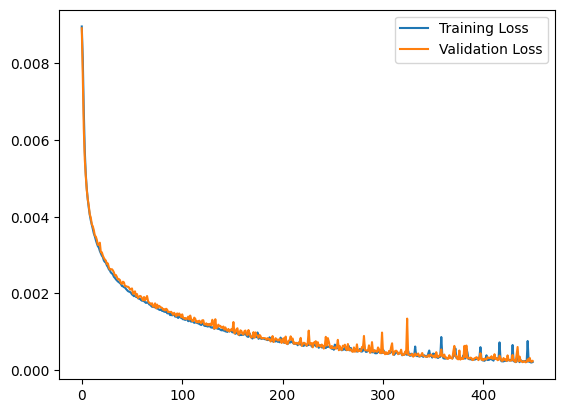

In [65]:

plt.figure()
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.show()

In [67]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))


Test set: Average loss: 0.0025, Accuracy: 688/989 (70%)




Test set: Average loss: 0.0025, Accuracy: 688/989 (70%)



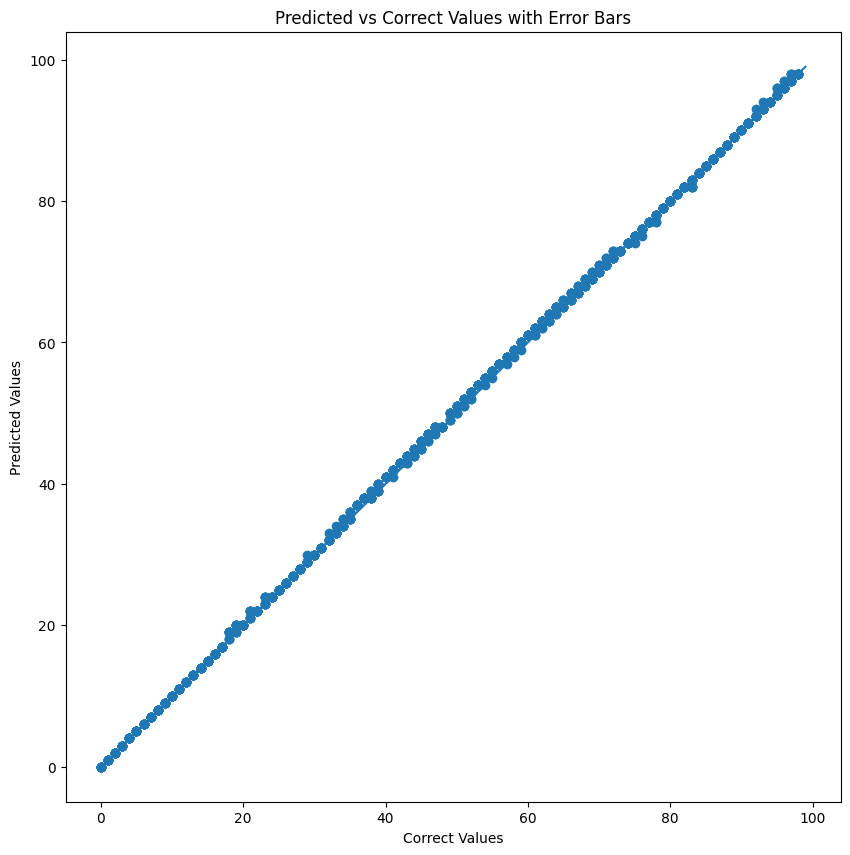

In [68]:
import matplotlib.pyplot as plt

model.eval()
test_loss = 0
correct = 0
preds = []
targets = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device).float(), target.to(device)
        output = model(data)
        test_loss += loss_fn(output, target).item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        preds.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

test_loss /= len(test_loader.dataset)

print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Calculate differences between predicted and actual values
diffs = np.array(preds) - np.array(targets)

# Calculate standard deviation of differences
std_dev = np.std(diffs)

# Plot predicted vs correct values with error bars
plt.figure(figsize=(10, 10))
# plt.errorbar(targets, preds, yerr=std_dev, fmt='o', alpha=0.5)
plt.scatter(targets, preds)
plt.plot(range(100))
plt.xlabel('Correct Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Correct Values with Error Bars')
plt.show()


In [69]:
targets = np.array(targets) 
preds = np.array(preds).reshape(targets.shape)
delta = preds - targets
mean_delta = (delta).mean()
std_delta =  (delta).std()
print(mean_delta, '+/-', std_delta) 

0.28816986855409504 +/- 0.47043166660469626


(array([  8.,   0.,   0.,   0.,   0., 688.,   0.,   0.,   0., 293.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

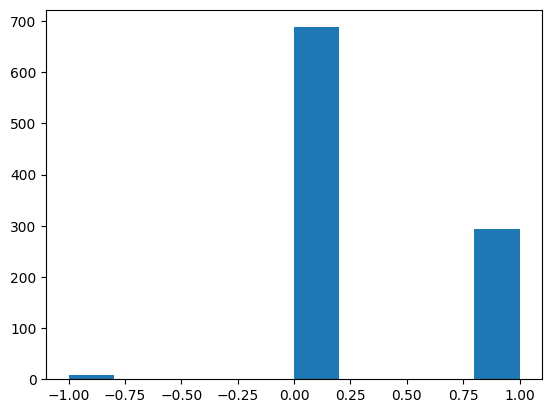

In [70]:
plt.hist(delta)